# Задача

 - Найти графовый набор данных для решения задачи предсказания (классификация вершин, обнаружение сообществ и т.д.).
 - Использовать несколько слоев GCNConv из библиотеки PyG для построения GCN модели.
 - Обучить полученную модель, подобрать гиперпараметры (например, learning rate) на валидационной выборке, и оценить качество предсказания на тестовой выборке.
 - (+5 баллов) Также представить самостоятельную реализацию слоя GCNConv, используя матричные операции. Повторить обучение с собственными слоями и сравнить результаты.

# Библиотеки

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.5.0+cu121


In [5]:
!pip install torch-scatter
!pip install torch_geometric

  Using cached torch_scatter-2.1.2.tar.gz (108 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=538974 sha256=f96a259bf027ea5e80ef2dfebdf42204a61a5f3157c7daec5c1930becbd5bbd6
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-scatter
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.8 MB/s eta 0:00:00


In [12]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from torch import Tensor
from torch_geometric.nn import GCNConv

import pandas as pd
from tqdm.auto import trange
import numpy as np

from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from itertools import product

In [7]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# Dataset

In [8]:

from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Processing...
Done!



Dataset: CiteSeer():
Number of graphs: 1
Number of features: 3703
Number of classes: 6

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
Number of nodes: 3327
Number of edges: 9104
Average node degree: 2.74
Number of training nodes: 120
Training node label rate: 0.04
Has isolated nodes: True
Has self-loops: False
Is undirected: True


In [10]:
class GCN(torch.nn.Module):
	def __init__(self, dataset, size_emb, conv_type=GCNConv):
		super().__init__()
		torch.manual_seed(42)
		self.conv1 = conv_type(dataset.num_features, size_emb*2)
		self.conv2 = conv_type(size_emb*2, size_emb)
		self.conv3 = conv_type(size_emb, dataset.num_classes)

	def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
		x = self.conv1(x, edge_index).relu()
		x = self.conv2(x, edge_index).relu()
		x = self.conv3(x, edge_index)
		return x

In [11]:
def train(data, model, optimizer, criterion):
	model.train()
	optimizer.zero_grad()  # Clear gradients.
	out = model(data.x, data.edge_index)  # Perform a single forward pass.
	loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
	loss.backward()  # Derive gradients.
	optimizer.step()  # Update parameters based on gradients.
	return loss

def validate(data, model):
  model.eval()
  out = model(data.x, data.edge_index)
  val_pred = out.argmax(dim=1)  # Use the class with highest probability.
  test_correct = val_pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
  test_acc = int(test_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
  return test_acc

def test(data, model):
	model.eval()
	out = model(data.x, data.edge_index)
	pred = out.argmax(dim=1)  # Use the class with highest probability.
	test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
	test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
	return test_acc

# Подбор параметров

In [13]:

embedding_sizes = [8, 16, 32, 64]  # Размер эмбеддингов
learning_rates = [0.1, 0.01, 0.001]
num_epochs = 50


criterion = CrossEntropyLoss()
results = {}

for size_emb, lr in product(embedding_sizes, learning_rates):
    model = GCN(dataset, size_emb)
    optimizer = Adam(model.parameters(), lr=lr)

    # Обучение модели
    for epoch in range(num_epochs):
        loss = train(data, model, optimizer, criterion)

    # Валидация
    val_acc = validate(data, model)
    test_acc = test(data, model)

    # Сохранение результатов
    params = f"size_emb={size_emb}, lr={lr}"
    results[params] = {
        "validation_accuracy": val_acc,
        "test_accuracy": test_acc,
        "final_loss": loss.item()
    }
    print(f"Finished: {params}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

# Печать лучших результатов
best_params = max(results, key=lambda k: results[k]["validation_accuracy"])
print("\nBest Parameters:")
print(best_params)
print("Results:", results[best_params])


Finished: size_emb=8, lr=0.1, Val Acc: 0.5700, Test Acc: 0.5480
Finished: size_emb=8, lr=0.01, Val Acc: 0.6700, Test Acc: 0.6570
Finished: size_emb=8, lr=0.001, Val Acc: 0.5640, Test Acc: 0.5450
Finished: size_emb=16, lr=0.1, Val Acc: 0.5800, Test Acc: 0.5780
Finished: size_emb=16, lr=0.01, Val Acc: 0.6340, Test Acc: 0.6160
Finished: size_emb=16, lr=0.001, Val Acc: 0.6620, Test Acc: 0.6490
Finished: size_emb=32, lr=0.1, Val Acc: 0.6000, Test Acc: 0.5970
Finished: size_emb=32, lr=0.01, Val Acc: 0.6180, Test Acc: 0.6050
Finished: size_emb=32, lr=0.001, Val Acc: 0.5020, Test Acc: 0.4730
Finished: size_emb=64, lr=0.1, Val Acc: 0.5560, Test Acc: 0.5200
Finished: size_emb=64, lr=0.01, Val Acc: 0.6200, Test Acc: 0.5990
Finished: size_emb=64, lr=0.001, Val Acc: 0.6240, Test Acc: 0.6200

Best Parameters:
size_emb=8, lr=0.01
Results: {'validation_accuracy': 0.67, 'test_accuracy': 0.657, 'final_loss': 0.2768068313598633}


# Вывод: лучшие результаты у модели с lr=0.01 и size_emb=8

In [19]:
lr = 0.01
size_emb = 8
epoch = 200
criterion = torch.nn.CrossEntropyLoss()
model = GCN(dataset, size_emb=size_emb)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

losses = []
epoch_pbar = trange(0, 200)
for epoch in epoch_pbar:
	loss = train(data, model, optimizer, criterion)
	losses.append(loss.item())
	epoch_pbar.set_description(f'Epoch {epoch:03d}, loss: {loss:.4f}')

  0%|          | 0/200 [00:00<?, ?it/s]

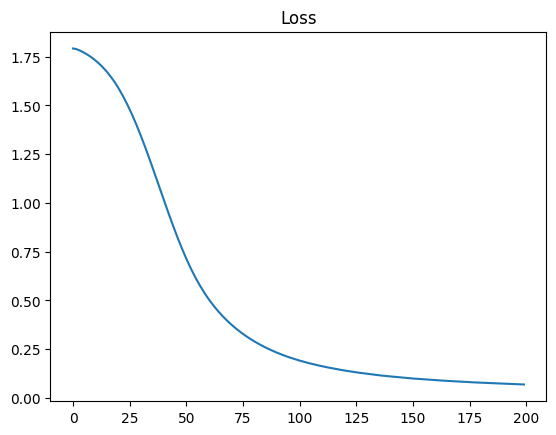

In [20]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Loss')
plt.show()

In [21]:
val_acc = validate(data, model)
print(f'Val accuracy: {val_acc:.4f}')

Val accuracy: 0.6520


In [22]:
test_acc = test(data, model)
print(f'Test accuracy: {val_acc:.4f}')

Test accuracy: 0.6520


# Визуализация графа, после обучения

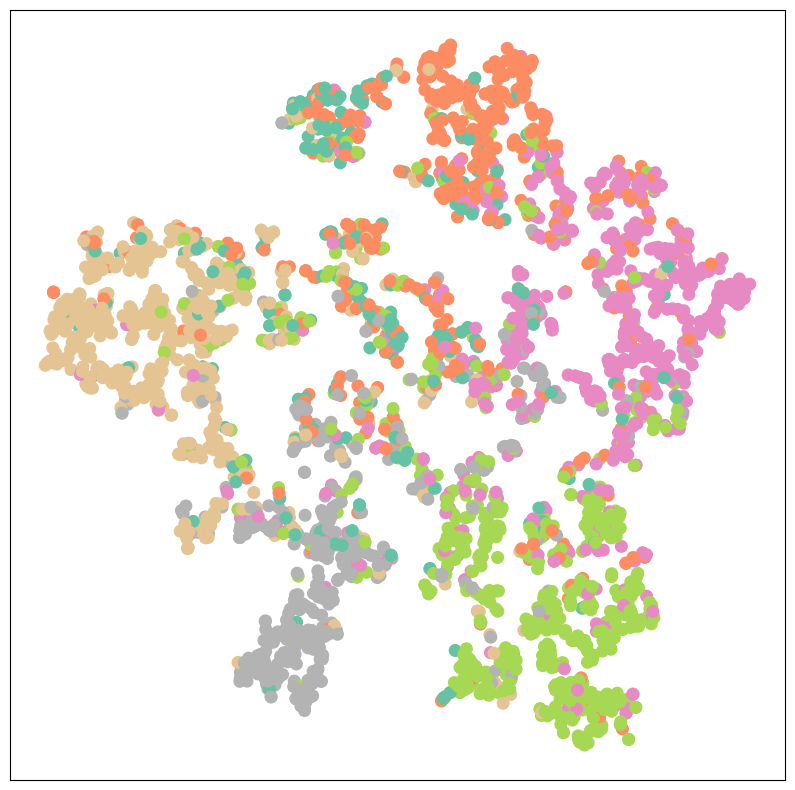

In [23]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

# Вывод:

можно отметить, что модель сумела выделить несколько классов и они разделимы визуально, но точк, которые находятся на пересечении классов классифицированы ошибочно



https://arxiv.org/pdf/1609.02907v4

In [34]:
import torch
from torch import nn
import math

class GraphConvLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.W = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.bias = nn.Parameter(torch.FloatTensor(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        # Инициализация весов и смещения
        nn.init.kaiming_uniform_(self.W, a=math.sqrt(5))
        nn.init.zeros_(self.bias)

    def add_self_loops(self, edge_index, num_nodes):
        """Добавление self-loops в граф"""
        self_loops = torch.arange(0, num_nodes, dtype=torch.long, device=edge_index.device)
        self_loops = self_loops.unsqueeze(0).repeat(2, 1)
        return torch.cat([edge_index, self_loops], dim=1)

    def normalize_adjacency(self, edge_index, num_nodes):
        """Нормализация матрицы смежности в формате edge_index"""
        # Степени узлов
        row, col = edge_index
        deg = torch.bincount(row, minlength=num_nodes)
        deg_inv_sqrt = torch.pow(deg, -0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0.0

        # Нормализация ребер
        values = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        return edge_index, values

    def forward(self, X, edge_index):
        num_nodes = X.size(0)

        # Добавление self-loops
        edge_index = self.add_self_loops(edge_index, num_nodes)

        # Нормализация
        edge_index, edge_weight = self.normalize_adjacency(edge_index, num_nodes)

        # Применение нормализованного Лапласиана: A_hat @ X @ W + b
        X = torch.mm(X, self.W)
        output = self.propagate(X, edge_index, edge_weight)
        return output + self.bias

    def propagate(self, X, edge_index, edge_weight):
        row, col = edge_index
        out = torch.zeros_like(X)
        out.index_add_(0, row, X[col] * edge_weight.unsqueeze(1))
        return out


In [35]:
lr = 0.01
size_emb = 8
epoch = 200
criterion = torch.nn.CrossEntropyLoss()
model = GCN(dataset, size_emb=size_emb, conv_type=GraphConvLayer)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

losses = []
epoch_pbar = trange(0, 50)
for epoch in epoch_pbar:
	loss = train(data, model, optimizer, criterion)
	losses.append(loss.item())
	epoch_pbar.set_description(f'Epoch {epoch:03d}, loss: {loss:.4f}')

  0%|          | 0/50 [00:00<?, ?it/s]

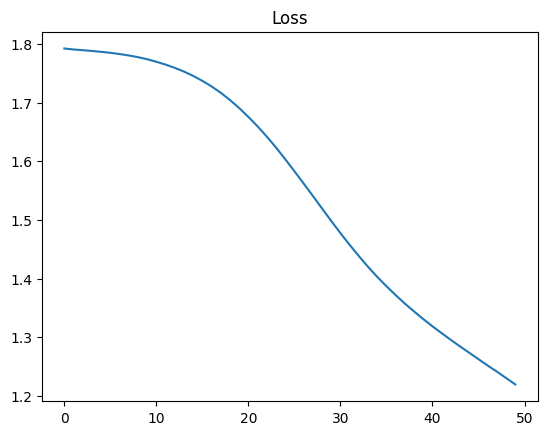

In [36]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Loss')
plt.show()

In [37]:
val_acc = validate(data, model)
print(f'Val accuracy: {val_acc:.4f}')

Val accuracy: 0.4200


In [38]:
test_acc = test(data, model)
print(f'Test accuracy: {val_acc:.4f}')

Test accuracy: 0.4200


# Вывод

Слабый результат классификации получился + работает медленнее